In [12]:
%matplotlib notebook

In [4]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [5]:
line = xt.Line.from_json('pimms_02_tuned.json')

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           


In [6]:
tw = line.twiss(method='4d')

num_particles = 5000
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)
delta = 5e-4 * np.random.normal(size=num_particles)
particles = line.build_particles(
    weight=1e10/num_particles,
    method='4d',
    nemitt_x=1e-6, nemitt_y=1e-6,
    x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
    delta=delta)
tab = tw.get_normalized_coordinates(particles)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [7]:
line.discard_tracker()

class SpillExcitation:
    def __init__(self):
        self.intensity = []
        self.amplitude = 1e-6
        self.gain = 0.
        self.amplitude_max = 100e-6
        self.target_rate = 0.98e10/ 15000
        self.n_ave = 100
        self._i_turn = 0

        self._amplitude_log = []
        self._rate_log = []
        self._gain_log = []

    def track(self, p):
        self.intensity.append(np.sum(p.weight[p.state > 0]))
        i_turn_0 = self._i_turn - self.n_ave
        if i_turn_0 < 0:
            i_turn_0 = 0
        rate = -(self.intensity[self._i_turn] - self.intensity[i_turn_0]) / (self._i_turn - i_turn_0)
        if self._i_turn > 10:
            self.amplitude -= self.amplitude * self.gain * (rate - self.target_rate)/self.target_rate
        if self.amplitude > self.amplitude_max:
            self.amplitude = self.amplitude_max
        if self.amplitude < 0:
            self.amplitude = 1e-7
        self._amplitude_log.append(self.amplitude)
        self._rate_log.append(rate)
        self._gain_log.append(self.gain)
        p.px[p.state > 0] += self.amplitude * np.random.normal(size=np.sum(p.state > 0))
        self._i_turn += 1

line.insert_element('spill_exc', SpillExcitation(), at_s=0)
import xobjects as xo
line.build_tracker(_context=xo.ContextCpu('auto'))

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [8]:
line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(x=[0, 0.5e-3], y=[0, 1.])
line.vars['kse1'] = line.vv['kse1'] * line.functions['fun_xsext'](line.vars['t_turn_s'])
line.vars['kse2'] = line.vv['kse2'] * line.functions['fun_xsext'](line.vars['t_turn_s'])

line.functions['fun_gain'] = xt.FunctionPieceWiseLinear(x=[0, 0.25e-3, 0.5e-3], y=[0, 0, .001])
line.vars['gain'] = line.functions['fun_gain'](line.vars['t_turn_s'])
line.element_refs['spill_exc'].gain = line.vars['gain']

line['septum'].max_x = 0.04

In [9]:
line.enable_time_dependent_vars = True
line.track(particles, num_turns=15000, with_progress=True)

Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


/var/folders/35/l_77xbn53_g_sw6hb551smyh0000gq/T/ipykernel_77079/3659685567.py:22: RuntimeWarning: invalid value encountered in scalar divide
  rate = -(self.intensity[self._i_turn] - self.intensity[i_turn_0]) / (self._i_turn - i_turn_0)
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


<IPython.core.display.Javascript object>


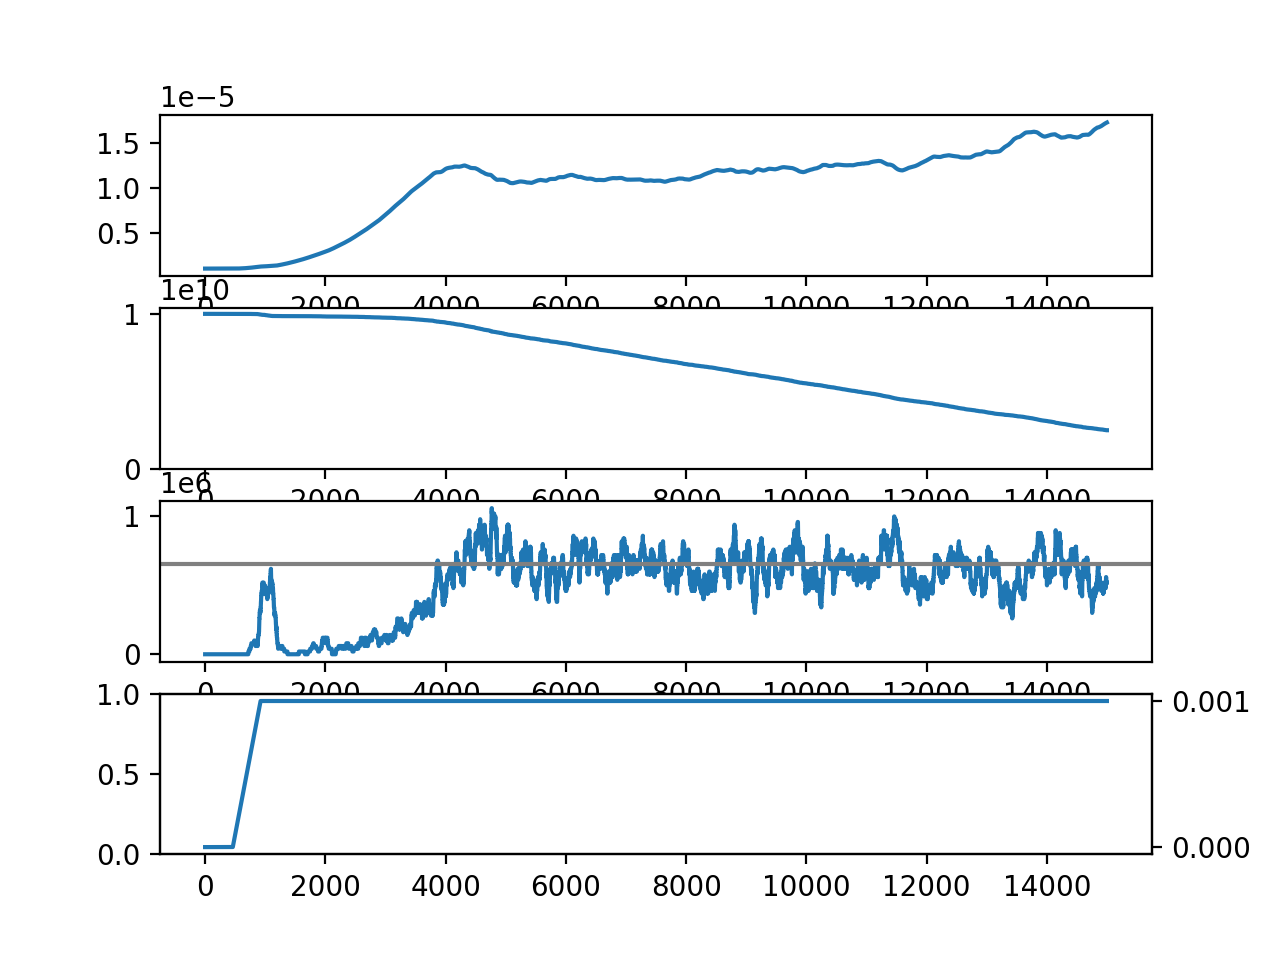

<IPython.core.display.Javascript object>


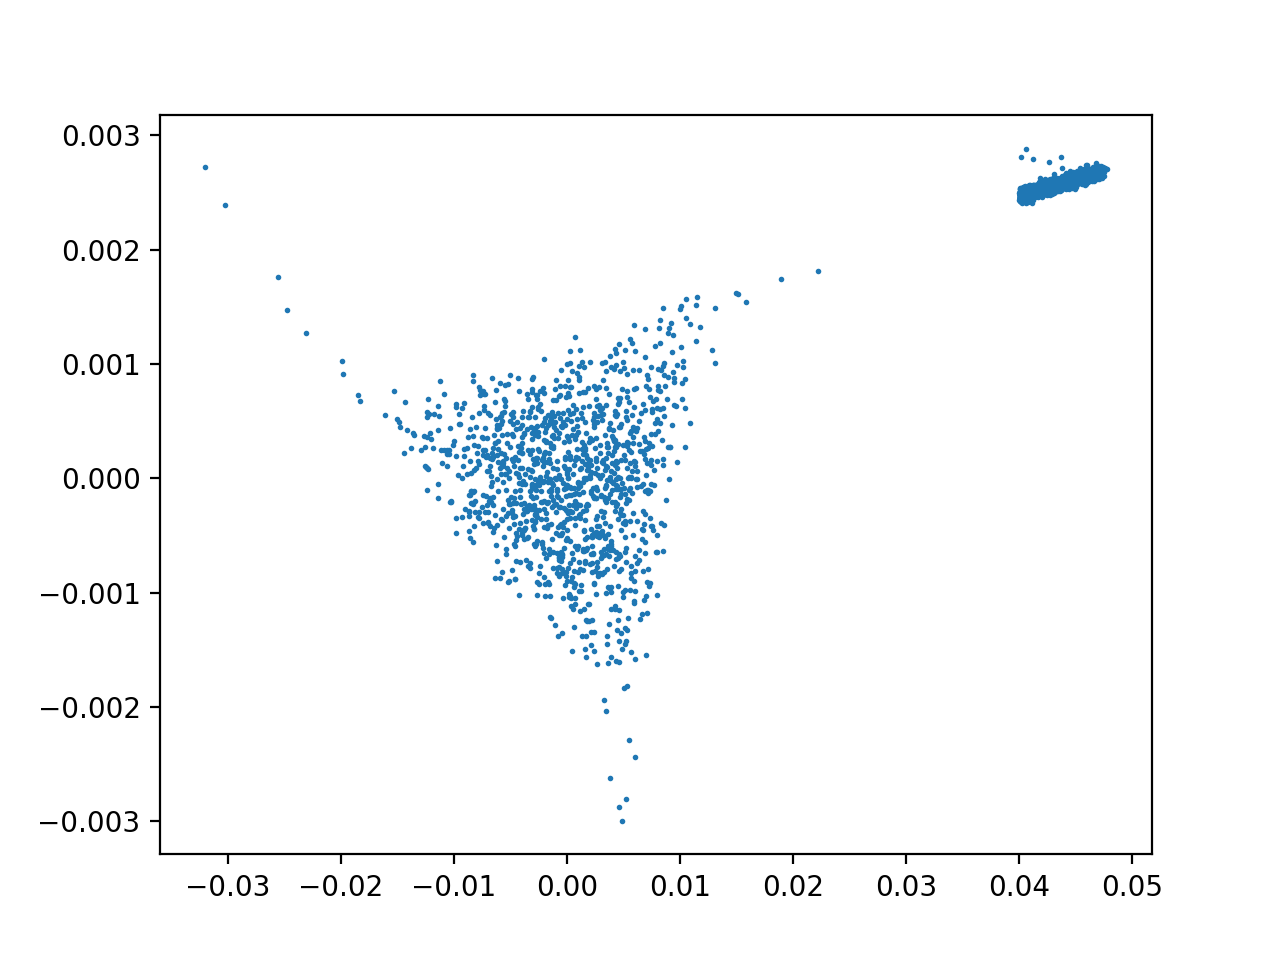

In [13]:
plt.figure(1000)
ax1 = plt.subplot(4,1,1)
plt.plot(line['spill_exc']._amplitude_log)

ax2 = plt.subplot(4,1,2, sharex=ax1)
plt.plot(line['spill_exc'].intensity)
plt.ylim(bottom=0)

ax3 = plt.subplot(4,1,3, sharex=ax1)
plt.plot(line['spill_exc']._rate_log)
plt.axhline(line['spill_exc'].target_rate, color='grey')

ax4 = plt.subplot(4,1,4, sharex=ax1)
ax4b = ax4.twinx()
plt.plot(line['spill_exc']._gain_log)

plt.figure(1001)
plt.plot(particles.x, particles.px, '.', markersize=2)
# plt.plot(x_fit_geom, px_fit_geom, 'grey')
plt.show()